In [157]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# load the ADHD CSV dataset file into a DataFrame
adhd_df = pd.read_csv('questionnaire_dataset.csv', sep=';')
X = pd.concat([adhd_df['group'], adhd_df.filter(regex='^tr\d+$')], axis=1)


#y = adhd_df['group'] # adhd group = 1/non-adhd group = 0
y = adhd_df['gender'] # men = 1/women = 0
column_names = X.columns

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


# Convert data to pandas DataFrame
#column_names = [f'column_{i}' for i in range(X.shape[1])]
real_data = pd.DataFrame(X, columns=column_names)
real_labels = y

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))

# Constants
NOISE_DIM = 50
NUM_CLASSES = 2
NUM_FEATURES = 44
BATCH_SIZE = 32
TRAINING_STEPS = 5000

In [158]:
# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='sigmoid')(hidden)
    #output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model


# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

In [159]:
# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [160]:
# Train GAN
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 500 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")


1/1 [==============================] - 0s 227ms/step
Step: 0, Discriminator Loss: 0.798561692237854, Generator Loss: 1.0348966121673584
1/1 [==============================] - 0s 21ms/step
Step: 500, Discriminator Loss: 0.24471931904554367, Generator Loss: 1.866849660873413
1/1 [==============================] - 0s 26ms/step
Step: 1000, Discriminator Loss: 0.4809683561325073, Generator Loss: 1.1098849773406982
1/1 [==============================] - 0s 25ms/step
Step: 1500, Discriminator Loss: 0.5103390216827393, Generator Loss: 1.21431565284729
1/1 [==============================] - 0s 24ms/step
Step: 2000, Discriminator Loss: 0.6267262399196625, Generator Loss: 0.8860092163085938
1/1 [==============================] - 0s 22ms/step
Step: 2500, Discriminator Loss: 0.5492332577705383, Generator Loss: 0.9463964700698853
1/1 [==============================] - 0s 20ms/step
Step: 3000, Discriminator Loss: 0.6178396940231323, Generator Loss: 0.9754456281661987
1/1 [============================

In [161]:
# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=[f'column_{i}' for i in range(generated_data.shape[1])])

In [162]:
# Generate 40 instances of class 1
generated_data = generate_data(generator, 1, 40)
print(generated_data)

2/2 [==============================] - 0s 5ms/step
        column_0  column_1  column_2  column_3  column_4  column_5  column_6  \
0   9.997367e-01  0.714728  0.978462  0.985302  0.907789  0.895108  0.675970   
1   8.003733e-08  0.807375  0.989610  0.998234  0.465278  0.991806  0.934103   
2   9.246873e-04  0.921833  0.938031  0.888179  0.350433  0.911571  0.822092   
3   3.791839e-23  0.037120  0.534401  0.628997  0.000234  0.016048  0.000008   
4   9.633025e-01  0.999601  0.999798  0.999983  0.987577  0.999975  0.999986   
5   1.000000e+00  0.319242  0.999917  1.000000  0.999606  0.989652  0.073050   
6   9.999970e-01  0.673900  0.988862  0.992353  0.961400  0.869326  0.757658   
7   9.999999e-01  0.979135  0.999728  1.000000  0.994875  0.999321  0.997557   
8   9.980926e-01  0.076854  0.988070  0.982019  0.517600  0.366295  0.004523   
9   9.969773e-01  0.995760  0.997012  0.999186  0.989039  0.998383  0.999692   
10  9.478495e-01  0.719133  0.833948  0.969115  0.547891  0.441843  0

In [163]:
# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 0, 50)
synthetic_data_class_1 = generate_data(generator, 1, 50)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1], ignore_index=True)
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=column_names)

# Rescale the generated data to match the original data range
cols_to_rescale = synthetic_data.columns[synthetic_data.columns != 'group']
synthetic_data[cols_to_rescale] = synthetic_data[cols_to_rescale].round()  # Assuming the original data range is 1-6

#synthetic_data = pd.DataFrame(synthetic_data, columns=column_names)
synthetic_data['group'] = synthetic_data['group'].round() # round to 0 or 1

# Create corresponding class labels
synthetic_labels = [0]*50 + [1]*50

# Add labels to the synthetic data
synthetic_data['gender'] = synthetic_labels

# Save synthetic data as a CSV file
synthetic_data.to_csv('synthetic_data.csv', index=False)

print("Minimum values after scaling back:")
print(synthetic_data.min())
print("\nMaximum values after scaling back:")
print(synthetic_data.max())

2/2 [==============================] - 0s 8ms/step
Minimum values after scaling back:
group     0.0
tr1       1.0
tr2       2.0
tr3       3.0
tr4       1.0
tr5       1.0
tr6       1.0
tr7       1.0
tr8       1.0
tr9       1.0
tr10      1.0
tr11      1.0
tr12      1.0
tr13      1.0
tr14      1.0
tr15      1.0
tr16      1.0
tr17      1.0
tr18      1.0
tr19      1.0
tr20      1.0
tr21      1.0
tr22      1.0
tr23      1.0
tr24      1.0
tr25      1.0
tr26      1.0
tr27      1.0
tr28      1.0
tr29      1.0
tr30      1.0
tr31      1.0
tr32      4.0
tr33      1.0
tr34      1.0
tr35      1.0
tr36      1.0
tr37      1.0
tr38      1.0
tr39      1.0
tr40      1.0
tr41      1.0
tr42      1.0
tr43      1.0
gender    0.0
dtype: float64

Maximum values after scaling back:
group     1.0
tr1       6.0
tr2       6.0
tr3       6.0
tr4       6.0
tr5       6.0
tr6       6.0
tr7       4.0
tr8       6.0
tr9       6.0
tr10      6.0
tr11      6.0
tr12      6.0
tr13      6.0
tr14      6.0
tr15      6.0
tr16     

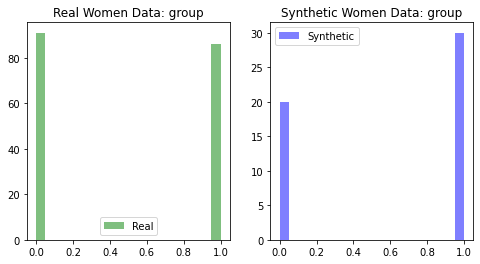

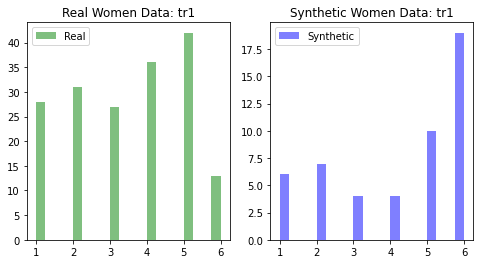

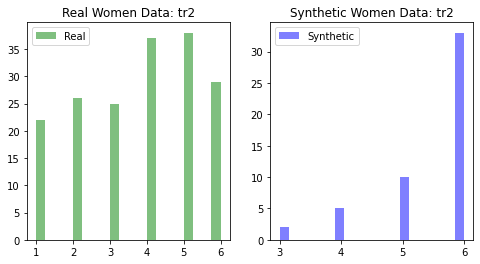

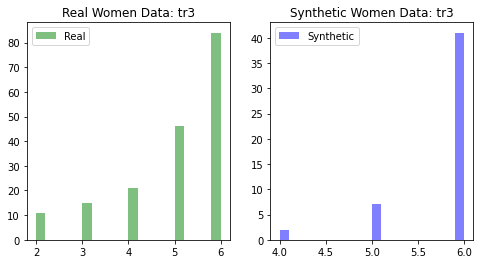

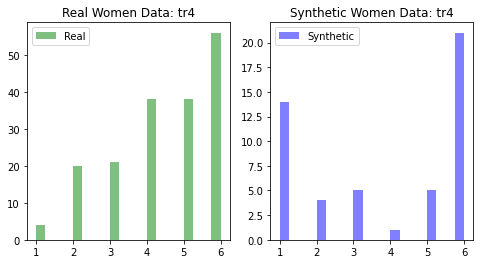

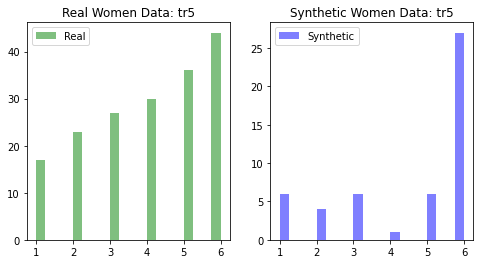

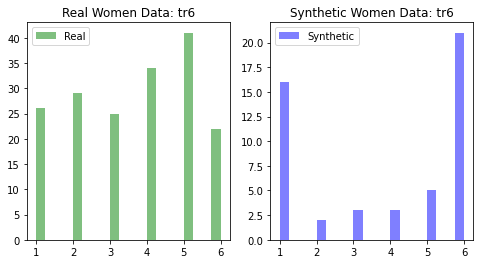

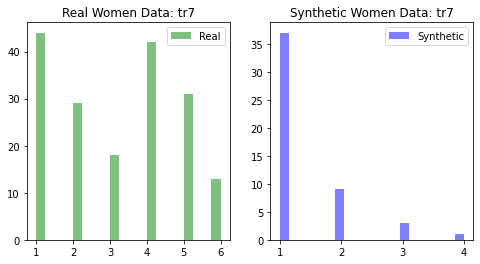

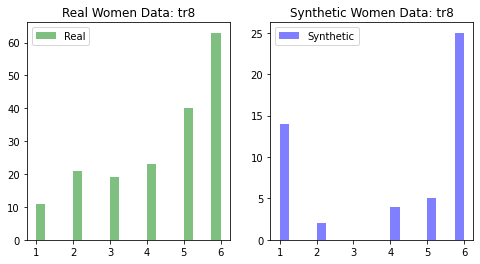

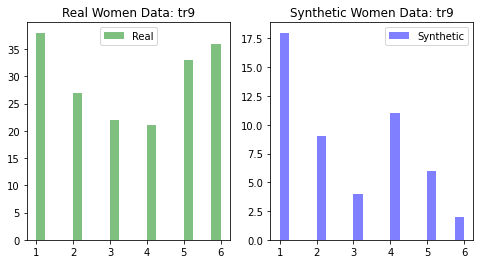

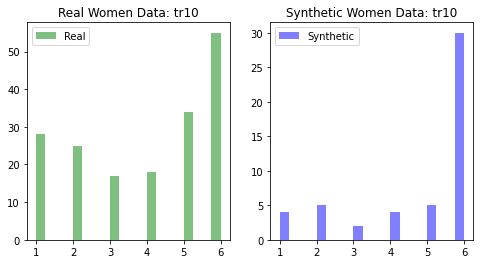

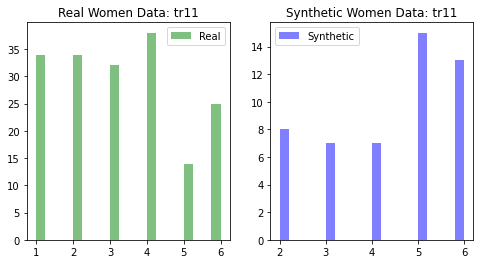

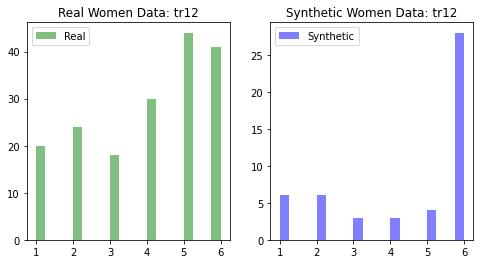

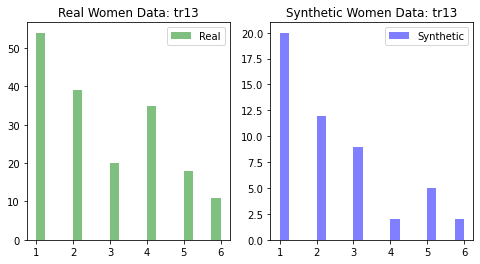

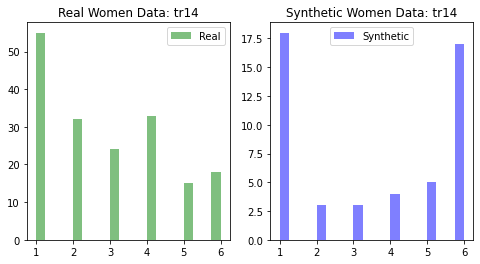

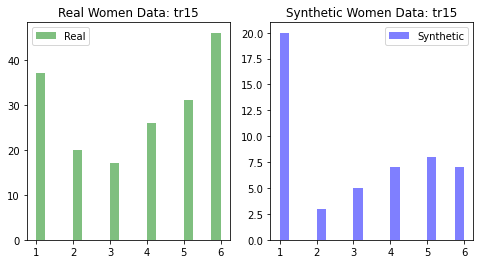

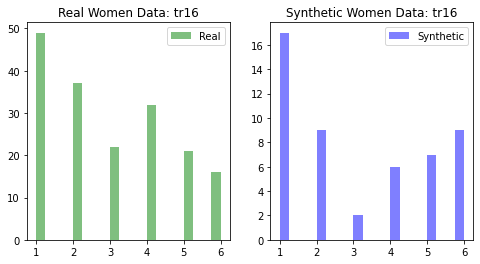

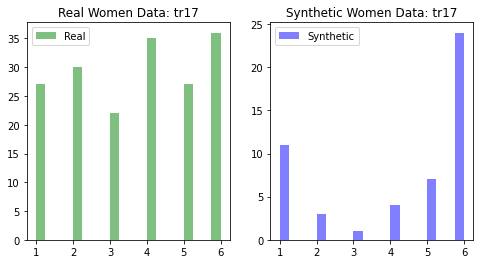

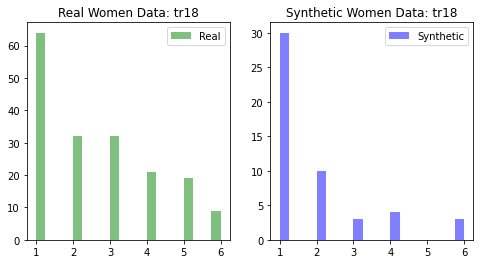

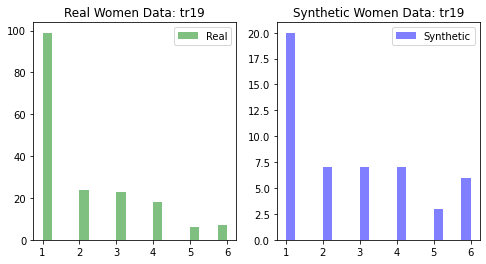

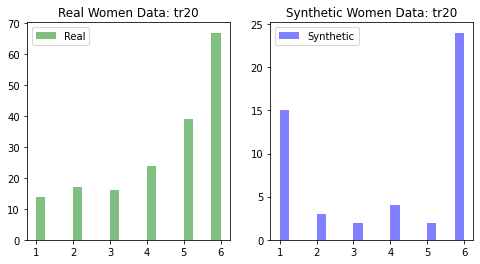

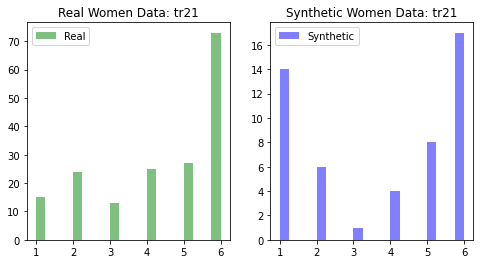

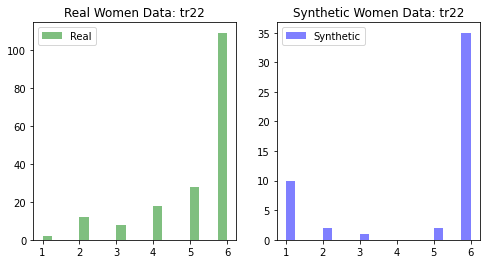

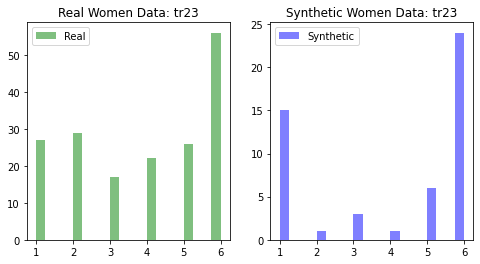

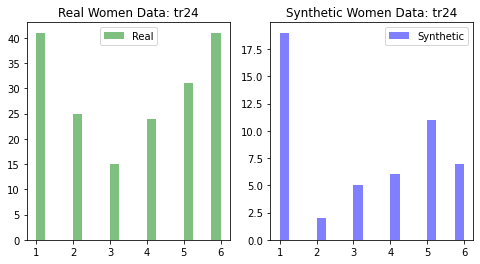

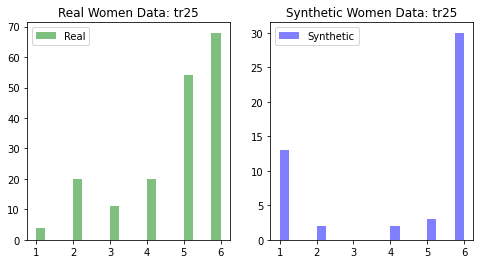

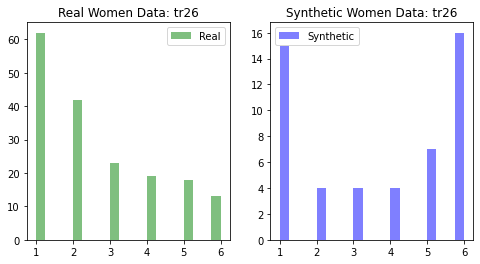

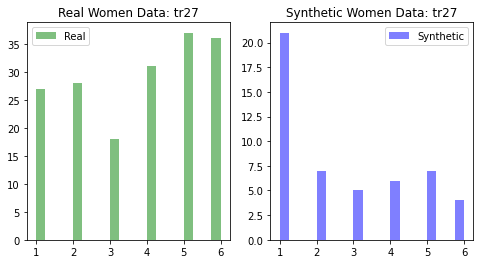

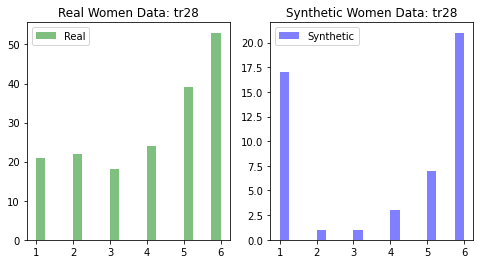

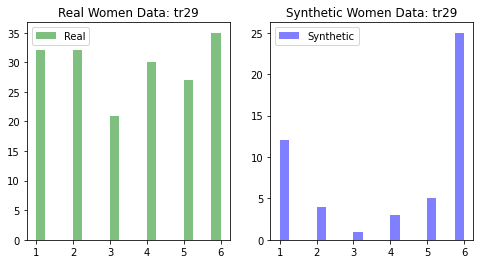

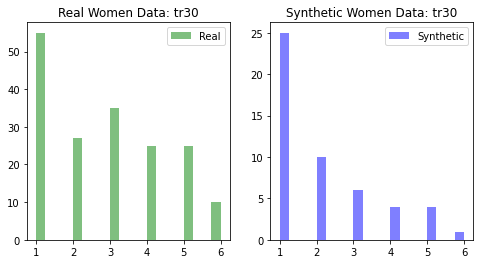

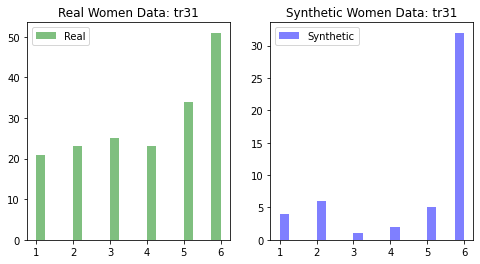

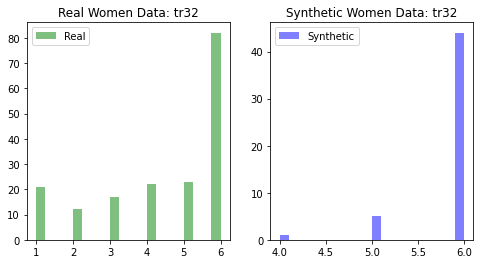

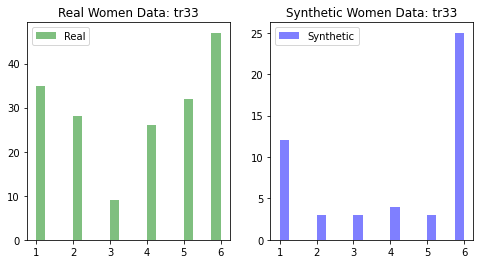

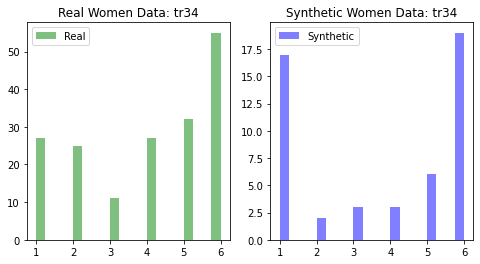

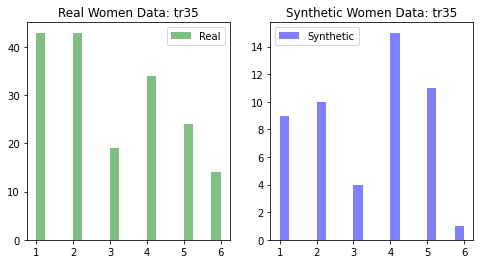

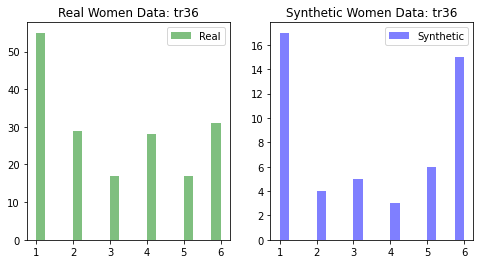

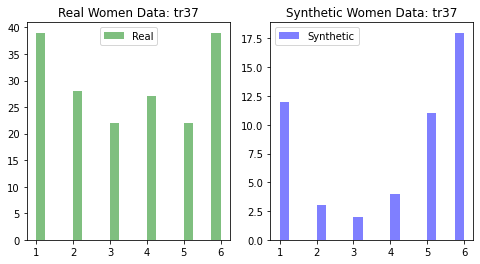

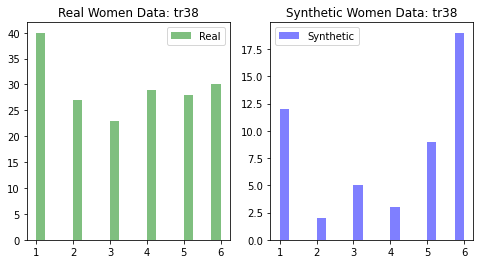

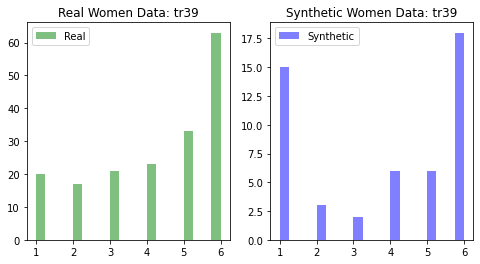

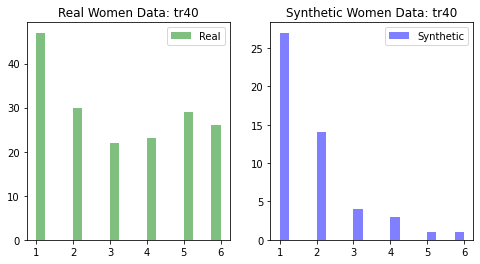

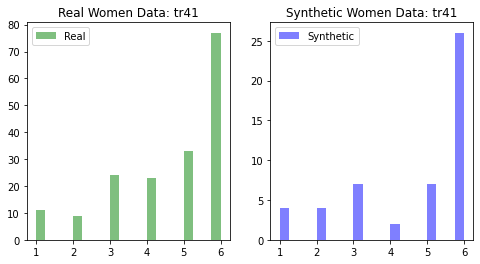

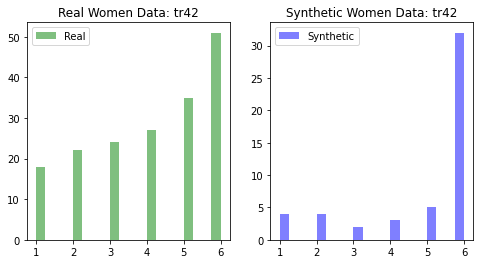

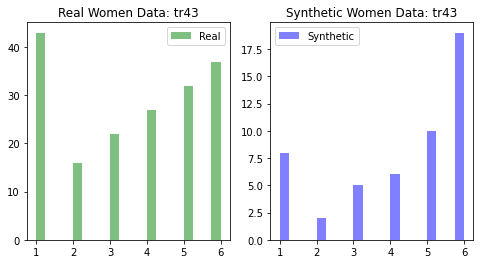

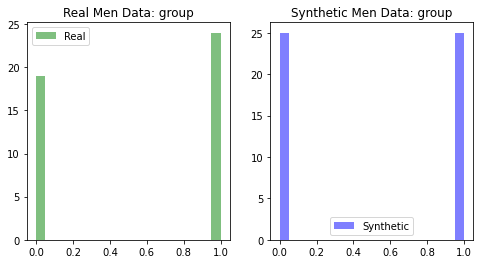

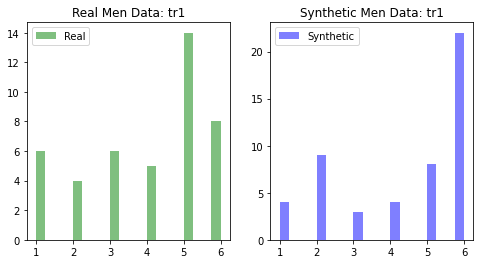

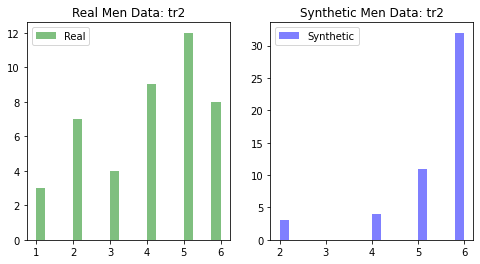

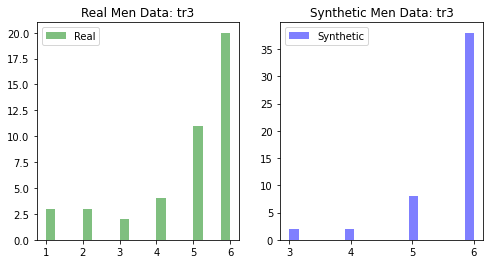

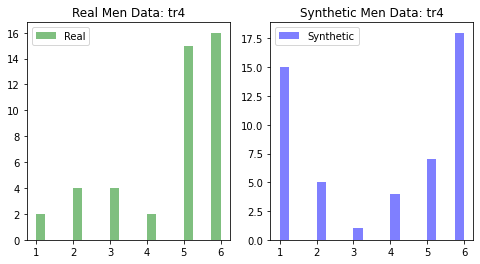

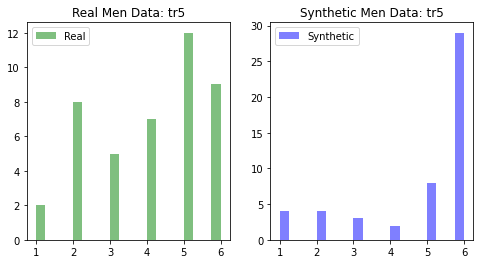

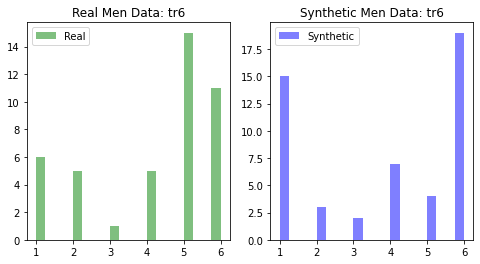

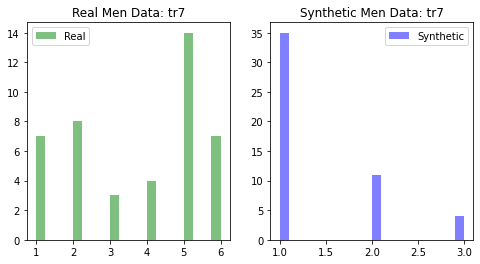

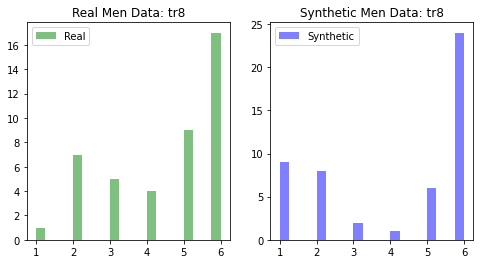

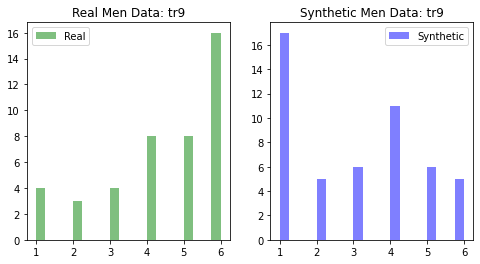

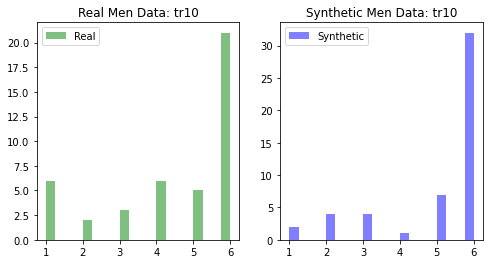

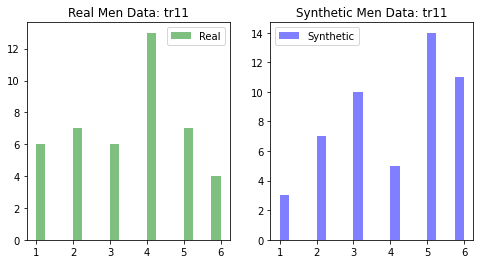

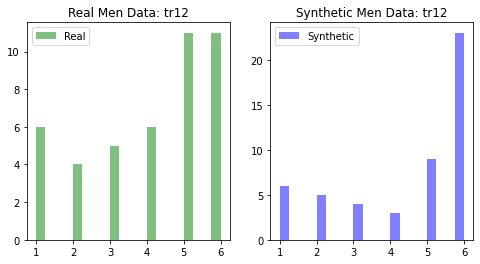

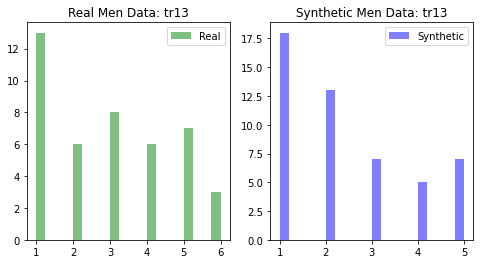

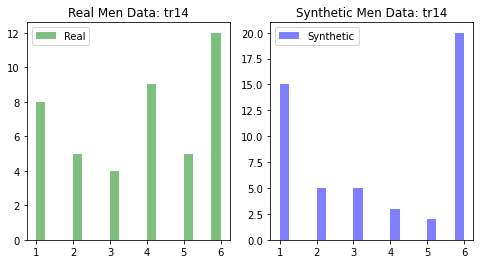

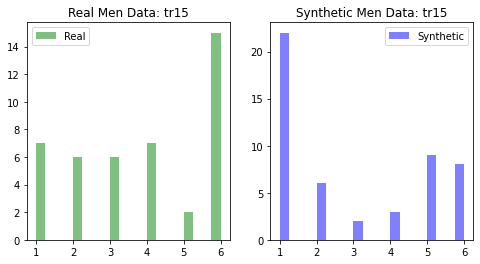

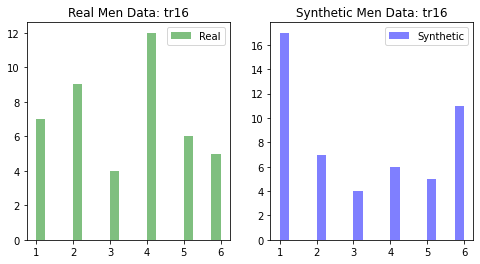

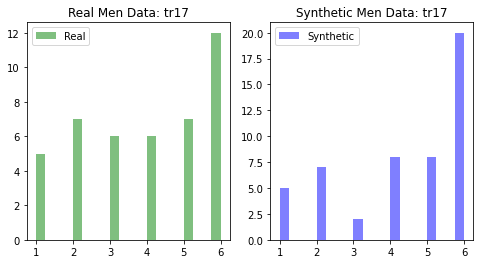

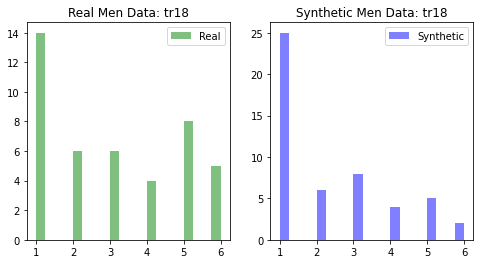

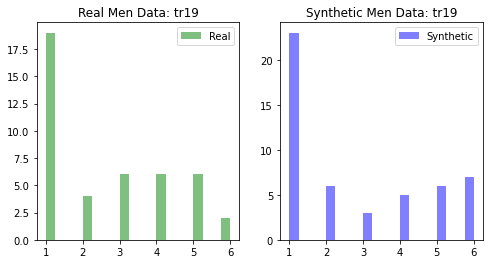

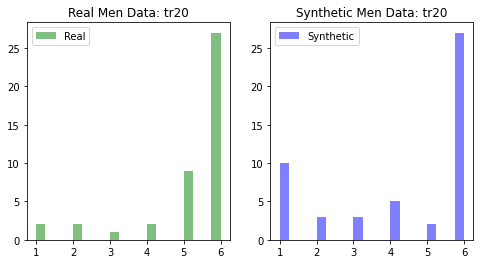

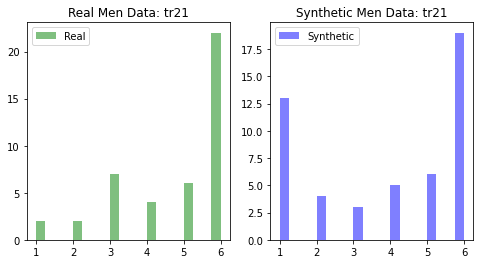

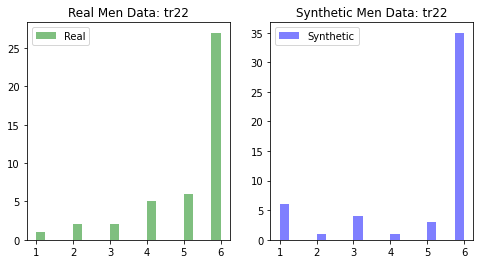

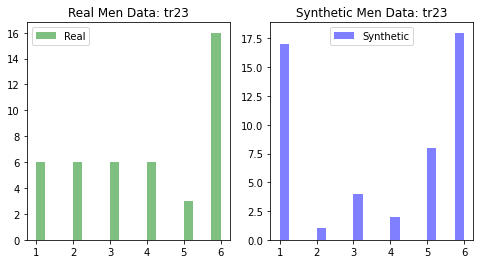

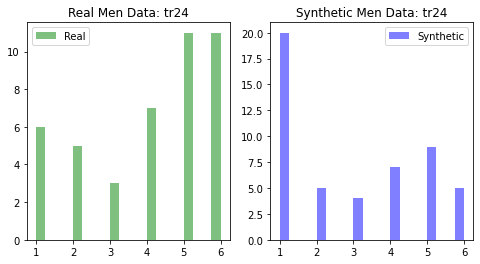

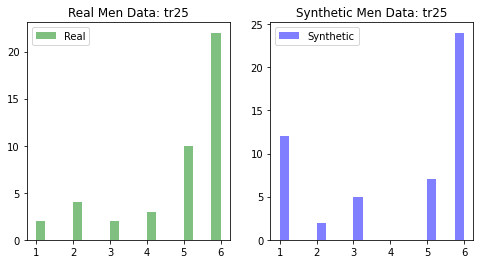

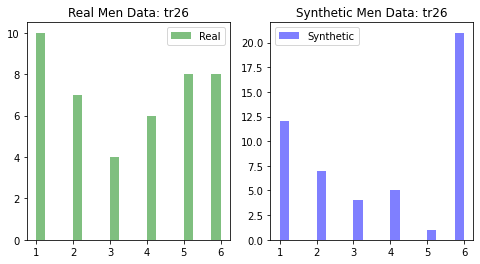

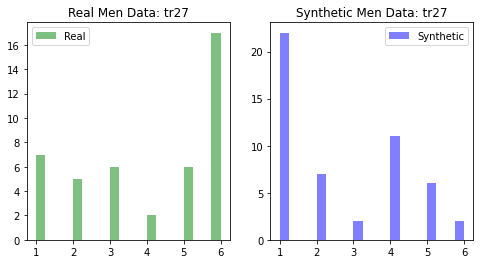

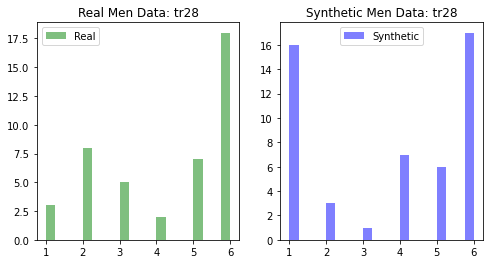

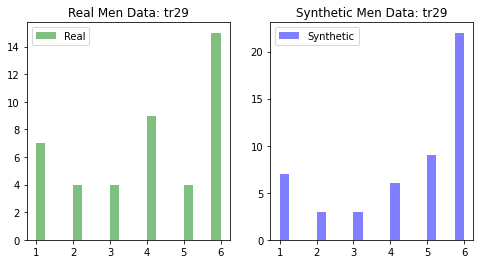

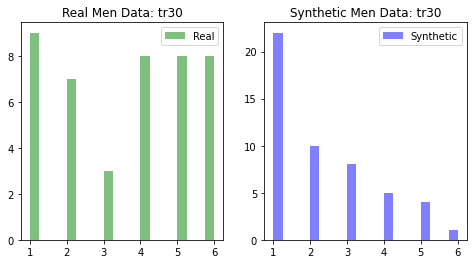

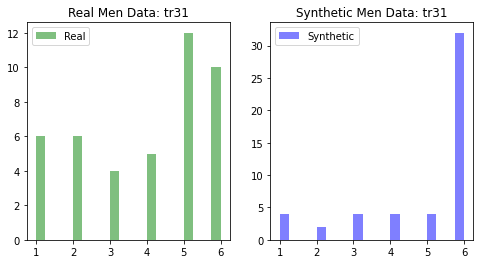

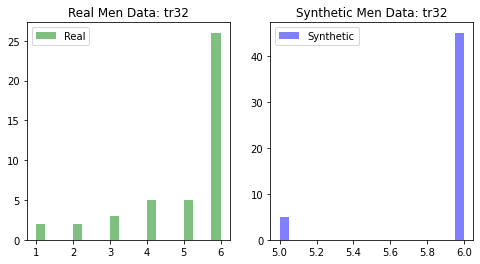

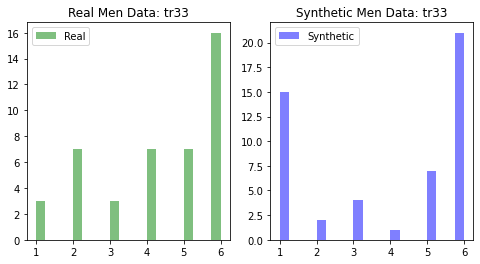

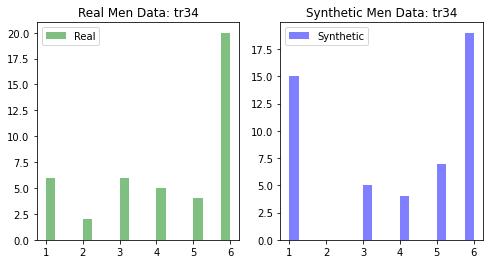

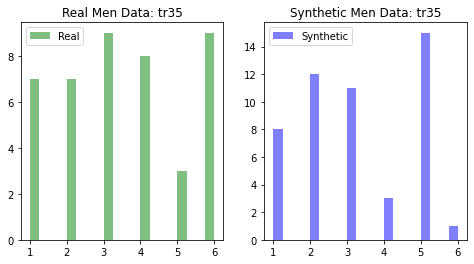

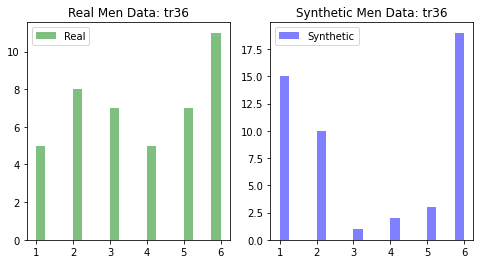

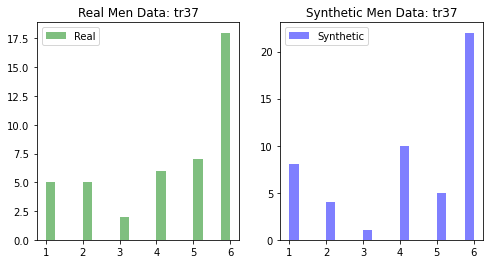

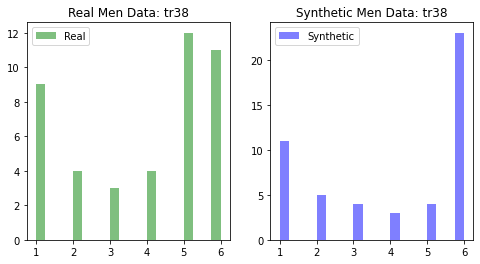

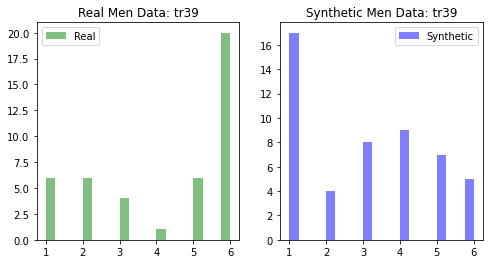

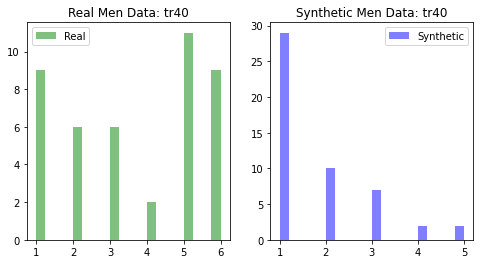

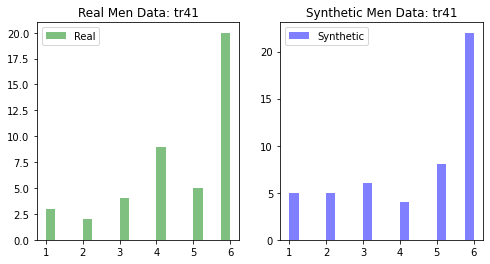

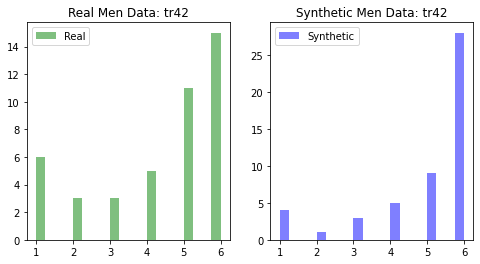

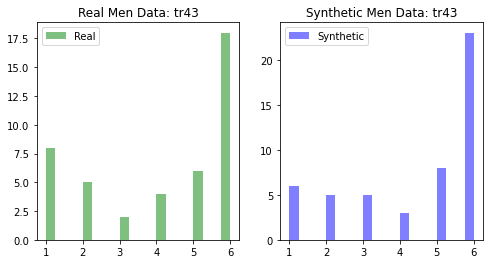

'\nfeatures = [\'sepal length (cm)\', \'sepal width (cm)\', \'petal length (cm)\', \'petal width (cm)\']\nfor i in range(len(features)):\n    for j in range(i+1, len(features)):\n        plt.figure(figsize=(10, 5))\n\n        plt.subplot(1, 2, 1)\n        plt.scatter(real_data[features[i]], real_data[features[j]], alpha=0.5, color=\'g\')\n        plt.title(f"Real Data: {features[i]} vs {features[j]}")\n\n        plt.subplot(1, 2, 2)\n        plt.scatter(synthetic_data[features[i]], synthetic_data[features[j]], alpha=0.5, color=\'b\')\n        plt.title(f"Synthetic Data: {features[i]} vs {features[j]}")\n\n        plt.show()\n'

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

# load the ADHD CSV dataset file into a DataFrame
real_data = pd.read_csv('questionnaire_dataset.csv', sep=';')

real_data_women = real_data[real_data['gender'] == 0]
real_data_men = real_data[real_data['gender'] == 1]

# Load the synthetic dataset
synthetic_data = pd.read_csv('synthetic_data.csv')

synthetic_data_women = synthetic_data[synthetic_data['gender'] == 0]
synthetic_data_men = synthetic_data[synthetic_data['gender'] == 1]

# For each feature, create a histogram for the real and synthetic data for women
for feature in column_names:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.hist(real_data_women[feature], bins=20, alpha=0.5, color='g', label='Real')
    plt.title(f"Real Women Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data_women[feature], bins=20, alpha=0.5, color='b', label='Synthetic')
    plt.title(f"Synthetic Women Data: {feature}")
    plt.legend()

    plt.show()

# For each feature, create a histogram for the real and synthetic data for men
for feature in column_names:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.hist(real_data_men[feature], bins=20, alpha=0.5, color='g', label='Real')
    plt.title(f"Real Men Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data_men[feature], bins=20, alpha=0.5, color='b', label='Synthetic')
    plt.title(f"Synthetic Men Data: {feature}")
    plt.legend()

    plt.show()

# For each pair of features, create a scatter plot for the real and synthetic data
"""
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(real_data[features[i]], real_data[features[j]], alpha=0.5, color='g')
        plt.title(f"Real Data: {features[i]} vs {features[j]}")

        plt.subplot(1, 2, 2)
        plt.scatter(synthetic_data[features[i]], synthetic_data[features[j]], alpha=0.5, color='b')
        plt.title(f"Synthetic Data: {features[i]} vs {features[j]}")

        plt.show()
"""

In [155]:
# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data (women):")
print(real_data_women[column_names].describe())
print("\nSummary statistics for the synthetic data (women):")
print(synthetic_data_women.describe())

Summary statistics for the real data (women):
            group         tr1         tr2         tr3         tr4         tr5  \
count  177.000000  177.000000  177.000000  177.000000  177.000000  177.000000   
mean     0.485876    3.406780    3.734463    5.000000    4.435028    4.000000   
std      0.501218    1.571609    1.631577    1.224745    1.441083    1.658312   
min      0.000000    1.000000    1.000000    2.000000    1.000000    1.000000   
25%      0.000000    2.000000    2.000000    4.000000    3.000000    3.000000   
50%      0.000000    4.000000    4.000000    5.000000    5.000000    4.000000   
75%      1.000000    5.000000    5.000000    6.000000    6.000000    5.000000   
max      1.000000    6.000000    6.000000    6.000000    6.000000    6.000000   

              tr6         tr7         tr8         tr9  ...        tr34  \
count  177.000000  177.000000  177.000000  177.000000  ...  177.000000   
mean     3.570621    3.146893    4.406780    3.519774  ...    4.000000   
st

In [156]:
# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data (men):")
print(real_data_men[column_names].describe())
print("\nSummary statistics for the synthetic data (men):")
print(synthetic_data_men.describe())

Summary statistics for the real data (men):
           group        tr1        tr2        tr3        tr4        tr5  \
count  43.000000  43.000000  43.000000  43.000000  43.000000  43.000000   
mean    0.558140   3.953488   4.023256   4.790698   4.674419   4.069767   
std     0.502486   1.703686   1.565831   1.582014   1.523169   1.564416   
min     0.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
25%     0.000000   3.000000   3.000000   4.000000   4.000000   3.000000   
50%     1.000000   5.000000   4.000000   5.000000   5.000000   4.000000   
75%     1.000000   5.000000   5.000000   6.000000   6.000000   5.000000   
max     1.000000   6.000000   6.000000   6.000000   6.000000   6.000000   

             tr6        tr7        tr8        tr9  ...       tr34       tr35  \
count  43.000000  43.000000  43.000000  43.000000  ...  43.000000  43.000000   
mean    4.186047   3.720930   4.488372   4.418605  ...   4.372093   3.465116   
std     1.776243   1.803774   1.609083  